## RevLVDT + VC Simulation

In [16]:
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt

# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

#### Main Parameters

In [17]:
Description_Txt   = "RevLVDT_VC ETpathfinder large IP geometry"
outputfile        = 'RevLVDT_VC_DC_1A_32AWG_10mm_6_7_7_m.out'
OutCoil_Distance  = 54.5 # distance between mid points of outer coils. Space between coils is then OutCoil_Distance - OutCoil_Height
InnCoil_Distance  = 0 # offset distance for inner coil
InnCoil_Current   = 0.00 # Normal LVDT: put current on inner coil
OutCoil_Current   = 1.00 # Reversed LVDT: put current on outer coils
SimulationFreq    = 0 # AC frequency = 0: simulate DC situation
NSteps            = 10
StepSize          = 1
InnCoil_Offset    = -5

# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-10) for the linear solver
femm.mi_probdef( SimulationFreq, 'millimeters', 'axi', 1.0e-10)

#### InnerCoil Parameters

In [18]:
InnCoil_WireType     = "32 AWG"
InnCoil_WireDiam     = 0.2032    # with heavy build, diameter: 0.23876
InnCoil_WireInsul    = 0.0178
InnCoil_NrWireLayers = 6
InnCoil_InRadius     = 11
InnCoil_Height       = 24

#### OutCoil Parameters

In [19]:
UppOutCoil_WireType     = "32 AWG"
UppOutCoil_WireDiam     = 0.2032
UppOutCoil_WireInsul    = 0.0178
UppOutCoil_NrWireLayers = 7
UppOutCoil_InRadius     = 35
UppOutCoil_Height       = 13.5

LowOutCoil_WireType     = "32 AWG"
LowOutCoil_WireDiam     = 0.2032
LowOutCoil_WireInsul    = 0.0178
LowOutCoil_NrWireLayers = 7
LowOutCoil_InRadius     = 35
LowOutCoil_Height       = 13.5

#### VoiceCoil Magnet Parameters

In [20]:
Magnet_Length    =  40
Magnet_Diameter  = 10
Magnet_Material  = "N40"
Magnet_VertShift =  0 

#### Position calculation for all Coils

In [21]:
# InnerCoil position 
InnCoil_OutRadius = InnCoil_InRadius +((InnCoil_WireDiam + InnCoil_WireInsul * 2) * InnCoil_NrWireLayers)
InnCoil_LowEnd = (InnCoil_Distance - InnCoil_Height) / 2 
InnCoil_UppEnd = InnCoil_LowEnd + InnCoil_Height
InnCoil_NrWind_p_Layer = (InnCoil_Height) / (InnCoil_WireDiam + InnCoil_WireInsul * 2)
InnCoil_NrWindings = InnCoil_NrWind_p_Layer * InnCoil_NrWireLayers
InnCoil_Circuit = "InnCoil_Circuit"

print("Inner coil:\n" 
      "Inner radius = {:.2f}".format(InnCoil_InRadius), 
      "Outer radius = {:.2f}".format(InnCoil_OutRadius),
      "Lower end = {:.2f}".format(InnCoil_LowEnd), 
      "Upper end = {:.2f}".format(InnCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(InnCoil_NrWind_p_Layer), 
      "Total windings = {:.2f}".format(InnCoil_NrWindings))

# Total length Calculation
InnCoil_TotalWire = 0
for i in range(0,InnCoil_NrWireLayers):
    #circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
    circ= 2*np.pi*(InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul * 2))
    InnCoil_TotalWire += circ*InnCoil_NrWind_p_Layer    
print("Total length of wire (mm):", InnCoil_TotalWire)
print("\n")

# UppOutCoil position 
UppOutCoil_OutRadius = UppOutCoil_InRadius + ((UppOutCoil_WireDiam + UppOutCoil_WireInsul * 2) * UppOutCoil_NrWireLayers)
UppOutCoil_LowEnd = (OutCoil_Distance - UppOutCoil_Height) / 2
UppOutCoil_UppEnd = UppOutCoil_LowEnd + UppOutCoil_Height
UppOutCoil_NrWind_p_Layer = (UppOutCoil_Height) / (UppOutCoil_WireDiam + UppOutCoil_WireInsul * 2)
UppOutCoil_NrWindings = UppOutCoil_NrWind_p_Layer * UppOutCoil_NrWireLayers
UppOutCoil_Circuit = "UppOutCoil_Circuit"

print("Upper outer coil:\n"
      "Inner radius = {:.2f}".format(UppOutCoil_InRadius),
      "Outer radius = {:.2f}".format(UppOutCoil_OutRadius),
      "Lower end = {:.2f}".format(UppOutCoil_LowEnd),
      "Upper end = {:.2f}".format(UppOutCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(UppOutCoil_NrWind_p_Layer),
      "Total windings = {:.2f}".format(UppOutCoil_NrWindings))

# Total length Calculation
UppOutCoil_TotalWire = 0
for i in range(0,UppOutCoil_NrWireLayers):
    #circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul))
    circ = 2*np.pi*(UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul*2))
    UppOutCoil_TotalWire += circ*UppOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", UppOutCoil_TotalWire)
print("\n")

# LowOutCoil position
LowOutCoil_OutRadius = LowOutCoil_InRadius + ((LowOutCoil_WireDiam + LowOutCoil_WireInsul * 2) * LowOutCoil_NrWireLayers)
LowOutCoil_UppEnd = -1*(OutCoil_Distance - LowOutCoil_Height) / 2
LowOutCoil_LowEnd = LowOutCoil_UppEnd - LowOutCoil_Height
LowOutCoil_NrWind_p_Layer = (LowOutCoil_UppEnd-LowOutCoil_LowEnd) / (LowOutCoil_WireDiam + LowOutCoil_WireInsul * 2)
LowOutCoil_NrWindings = LowOutCoil_NrWind_p_Layer * LowOutCoil_NrWireLayers
LowOutCoil_Circuit = "LowOutCoil_Circuit"

print("Lower outer coil:\n"
      "Inner radius = {:.2f}".format(LowOutCoil_InRadius),
      "Outer radius = {:.2f}".format(LowOutCoil_OutRadius),
      "Lower end = {:.2f}".format(LowOutCoil_LowEnd),
      "Upper end = {:.2f}".format(LowOutCoil_UppEnd),
      "#Windings/layer = {:.2f}".format(LowOutCoil_NrWind_p_Layer),
      "Total windings = {:.2f}".format(LowOutCoil_NrWindings))

# Total length Calculation
LowOutCoil_TotalWire = 0
for i in range(0,LowOutCoil_NrWireLayers):
    #circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
    circ = 2*np.pi*(LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul*2))
    LowOutCoil_TotalWire += circ*LowOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", LowOutCoil_TotalWire)
print("\n")

# Magnet Position
Magnet_UppEnd = Magnet_Length / 2 + Magnet_VertShift
Magnet_LowEnd = -Magnet_Length / 2 + Magnet_VertShift
Magnet_Radius = Magnet_Diameter / 2

print("Voice coil magnet:\n"
      "Magnet Radius = {:.2f}".format(Magnet_Radius),
      "Upper end = {:.2f}".format(Magnet_UppEnd),
      "Lower end = {:.2f}".format(Magnet_LowEnd))


Inner coil:
Inner radius = 11.00 Outer radius = 12.43 Lower end = -12.00 Upper end = 12.00 #Windings/layer = 100.50 Total windings = 603.02
Total length of wire (mm): 43939.35678835879


Upper outer coil:
Inner radius = 35.00 Outer radius = 36.67 Lower end = 20.50 Upper end = 34.00 #Windings/layer = 56.53 Total windings = 395.73
Total length of wire (mm): 88806.55691857403


Lower outer coil:
Inner radius = 35.00 Outer radius = 36.67 Lower end = -34.00 Upper end = -20.50 #Windings/layer = 56.53 Total windings = 395.73
Total length of wire (mm): 88806.55691857403


Voice coil magnet:
Magnet Radius = 5.00 Upper end = 20.00 Lower end = -20.00


#### Build Geometry

In [22]:
# InnerCoil Structure
femm.mi_drawrectangle(InnCoil_InRadius, InnCoil_UppEnd, InnCoil_OutRadius, InnCoil_LowEnd)
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)
femm.mi_getmaterial(InnCoil_WireType)
femm.mi_clearselected()
femm.mi_selectrectangle(InnCoil_InRadius,InnCoil_UppEnd, InnCoil_OutRadius, InnCoil_LowEnd, 4)
femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(InnCoil_InRadius + InnCoil_WireDiam,InnCoil_LowEnd + (InnCoil_Height/2))
femm.mi_selectlabel(  InnCoil_InRadius + InnCoil_WireDiam,InnCoil_LowEnd + (InnCoil_Height/2))
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 1 ,InnCoil_NrWindings)
femm.mi_clearselected()

# UpperOutCoil Structure
femm.mi_drawrectangle(UppOutCoil_InRadius, UppOutCoil_UppEnd, UppOutCoil_OutRadius, UppOutCoil_LowEnd)
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current,1)
femm.mi_getmaterial(UppOutCoil_WireType)
femm.mi_clearselected()
femm.mi_selectrectangle(UppOutCoil_InRadius, UppOutCoil_UppEnd, UppOutCoil_OutRadius, UppOutCoil_LowEnd, 4)
femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_addblocklabel(UppOutCoil_InRadius + UppOutCoil_WireDiam, UppOutCoil_UppEnd-(UppOutCoil_Height*0.5))
femm.mi_selectlabel(  UppOutCoil_InRadius + UppOutCoil_WireDiam, UppOutCoil_UppEnd-(UppOutCoil_Height*0.5))
femm.mi_setblockprop( UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0, 3, UppOutCoil_NrWindings)
femm.mi_clearselected()

# LowerOutCoil Structure
femm.mi_drawrectangle(LowOutCoil_InRadius,LowOutCoil_UppEnd, LowOutCoil_OutRadius, LowOutCoil_LowEnd)
femm.mi_addcircprop(LowOutCoil_Circuit, -OutCoil_Current, 1)
femm.mi_getmaterial(LowOutCoil_WireType)
femm.mi_clearselected()
femm.mi_selectrectangle(LowOutCoil_InRadius,LowOutCoil_UppEnd, LowOutCoil_OutRadius, LowOutCoil_LowEnd, 4)
femm.mi_setgroup(4)
femm.mi_clearselected()
femm.mi_addblocklabel(LowOutCoil_InRadius + LowOutCoil_WireDiam, LowOutCoil_LowEnd+(LowOutCoil_Height*0.5))
femm.mi_selectlabel(  LowOutCoil_InRadius + LowOutCoil_WireDiam, LowOutCoil_LowEnd+(LowOutCoil_Height*0.5))
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0, 4, LowOutCoil_NrWindings)
femm.mi_clearselected()

# Magnet Structure
femm.mi_drawrectangle(0, Magnet_UppEnd, Magnet_Radius,Magnet_LowEnd)
femm.mi_getmaterial(Magnet_Material)
femm.mi_clearselected()
femm.mi_selectrectangle(0, Magnet_UppEnd, Magnet_Radius,Magnet_LowEnd, 4)
femm.mi_setgroup(2)
femm.mi_clearselected()
femm.mi_addblocklabel(Magnet_Radius*0.5, Magnet_LowEnd+(Magnet_Length*0.5))
femm.mi_selectlabel(  Magnet_Radius*0.5, Magnet_LowEnd+(Magnet_Length*0.5))
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()

# AirSurrounding Structure
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10
# Airspace1
femm.mi_drawline(0, AirSpaceRadius_1, 0, -AirSpaceRadius_1)
femm.mi_drawarc(0, -AirSpaceRadius_1, 0, AirSpaceRadius_1, 180, 2)
femm.mi_getmaterial("Air")       
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0, 0, 0)
femm.mi_clearselected()
# Airspace2              
femm.mi_drawline(0, AirSpaceRadius_2, 0, -AirSpaceRadius_2)
femm.mi_drawarc(0, -AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_getmaterial("Air")  
femm.mi_clearselected()
femm.mi_addblocklabel(AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0, 0, 0)
femm.mi_clearselected()
# Boundary properties
femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
femm.mi_clearselected()
femm.mi_selectarcsegment(0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)               
femm.mi_clearselected()

#### Start Simulation and change the inner coil position

Output variables

In [23]:
UppOutCoil_Forces = np.zeros(NSteps+1)
LowOutCoil_Forces = np.zeros(NSteps+1)
Magnet_Forces = np.zeros(NSteps+1)
InnCoil_Positions = np.zeros(NSteps+1)
MetaData = np.zeros(NSteps+1)

Initial Offset position

In [24]:
femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

Simulation Loop

In [25]:
for i in range(0,NSteps+1):

    print(InnCoil_Offset + StepSize*i)
    InnCoil_Positions[i] = InnCoil_Offset + StepSize*i

    # Now, the finished input geometry can be displayed.
    #femm.mi_zoomnatural()
    femm.mi_zoom(-2,-50,50,50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('RevLVDT_VC_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        # Show Density Plot:
        femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
                #--legend,	(0=hide, 1=show)
                #--gscale,	(0=color, 1=greyscale)
                #--upper_B,	(upperlimit for display)
                #--lower_B,	(lowerlimit for display)
                #--type		("bmag", "breal", "bimag" FluxDensity)
                #--			("hmag", "hreal", "himag" FieldIntensity)
                #--			("jmag", "jreal", "jimag" CurrentDensity)
        femm.mo_zoom(-2,-50,50,50)
        femm.mo_refreshview()

    # Retrieve the Force on the Upper-OutCoil
    femm.mo_groupselectblock(3)
    UppOut_Force19 = femm.mo_blockintegral(19)
    femm.mo_clearblock()

    # Retrieve the Force on the Lower-OutCoil
    femm.mo_groupselectblock(4)
    LowOut_Force19 = femm.mo_blockintegral(19)
    femm.mo_clearblock()

    # Retrieve the Force on the magnet
    femm.mo_groupselectblock(2)
    Magn_Force19 = femm.mo_blockintegral(19)
    femm.mo_clearblock()

    print("Upper Outer Coil force = ", UppOut_Force19, "Lower Outer Coil force = ", LowOut_Force19, "Magnet force = ", Magn_Force19)
    UppOutCoil_Forces[i] = UppOut_Force19
    LowOutCoil_Forces[i] = LowOut_Force19
    Magnet_Forces[i] = Magn_Force19

    # Translate inner coil to different distance
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

-5
Upper Outer Coil force =  -0.3157413218444981 Lower Outer Coil force =  -0.4414734221082274 Magnet force =  0.7572776678273648
-4
Upper Outer Coil force =  -0.3230440895804734 Lower Outer Coil force =  -0.4441497974760321 Magnet force =  0.7662117956578665
-3
Upper Outer Coil force =  -0.3296144546542218 Lower Outer Coil force =  -0.4454555223996206 Magnet force =  0.7772647248812921
-2
Upper Outer Coil force =  -0.3352867856417304 Lower Outer Coil force =  -0.4453668465517876 Magnet force =  0.7811686415353676
-1
Upper Outer Coil force =  -0.3400144428489116 Lower Outer Coil force =  -0.4440008435616437 Magnet force =  0.7843600249042789
0
Upper Outer Coil force =  -0.3437930275534634 Lower Outer Coil force =  -0.4413925582217956 Magnet force =  0.7851220240964215
1
Upper Outer Coil force =  -0.3463241996009469 Lower Outer Coil force =  -0.4376756610629603 Magnet force =  0.7828538241005432
2
Upper Outer Coil force =  -0.3476936396937734 Lower Outer Coil force =  -0.432864708680691

In [26]:
 print(InnCoil_Positions)
print(UppOutCoil_Forces)
print(LowOutCoil_Forces)
print(Magnet_Forces)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[-0.31574132 -0.32304409 -0.32961445 -0.33528679 -0.34001444 -0.34379303
 -0.3463242  -0.34769364 -0.34775394 -0.346469   -0.34373358]
[-0.44147342 -0.4441498  -0.44545552 -0.44536685 -0.44400084 -0.44139256
 -0.43767566 -0.43286471 -0.42726803 -0.42064866 -0.41337554]
[0.75727767 0.7662118  0.77726472 0.78116864 0.78436002 0.78512202
 0.78285382 0.78044927 0.77329683 0.76587027 0.75789453]


In [27]:
 if NSteps > 2:
    MetaData[0] = NSteps
    MetaData[1] = StepSize
    MetaData[2] = OutCoil_Current
    np.savetxt(outputfile, (InnCoil_Positions, UppOutCoil_Forces, LowOutCoil_Forces, Magnet_Forces, MetaData))

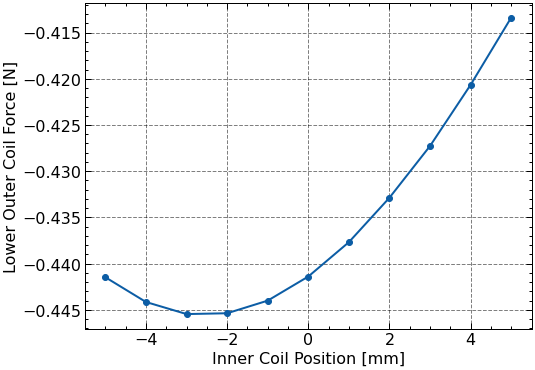

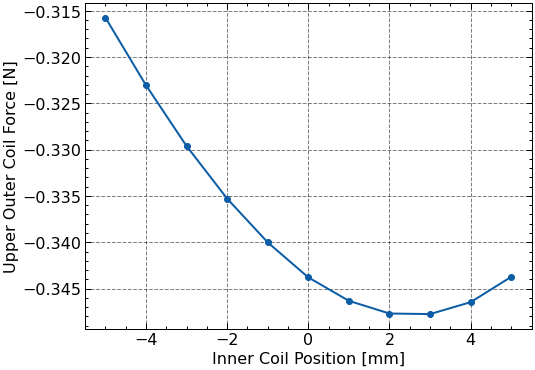

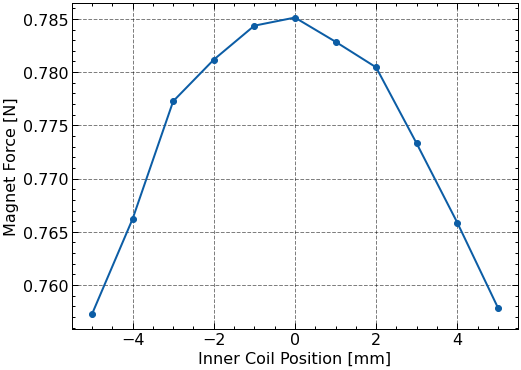

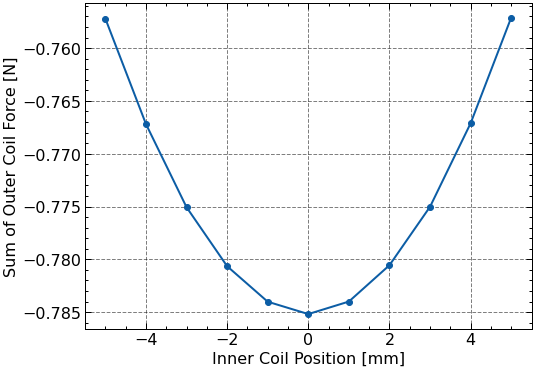

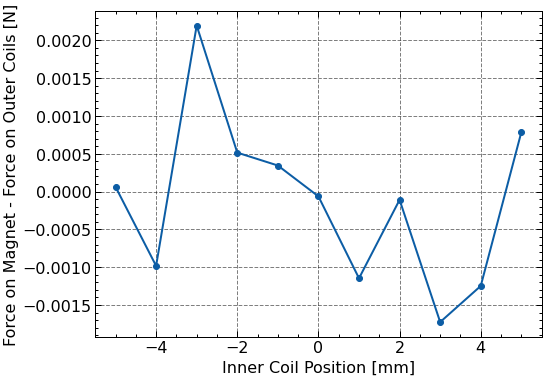

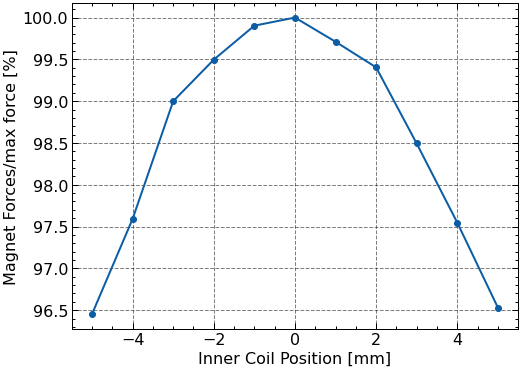

In [28]:
plt.style.use(['science','grid','notebook'])

plt.plot(InnCoil_Positions, LowOutCoil_Forces, 'o-')
plt.ylabel('Lower Outer Coil Force [N]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, UppOutCoil_Forces, 'o-')
plt.ylabel('Upper Outer Coil Force [N]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, Magnet_Forces, 'o-')
plt.ylabel('Magnet Force [N]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Forces + UppOutCoil_Forces,'o-')
plt.ylabel('Sum of Outer Coil Force [N]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, Magnet_Forces - abs(LowOutCoil_Forces + UppOutCoil_Forces),'o-')
plt.ylabel('Force on Magnet - Force on Outer Coils [N]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, Magnet_Forces/max(Magnet_Forces)*100, 'o-')
plt.ylabel('Magnet Forces/max force [%]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

Fitted parameters of function: [-1.11461363e-03 -1.19367402e-04  7.84943373e-01]


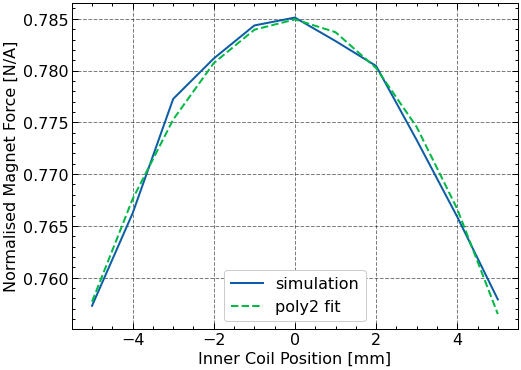

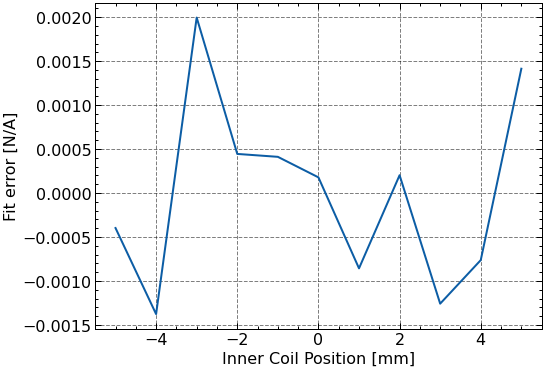

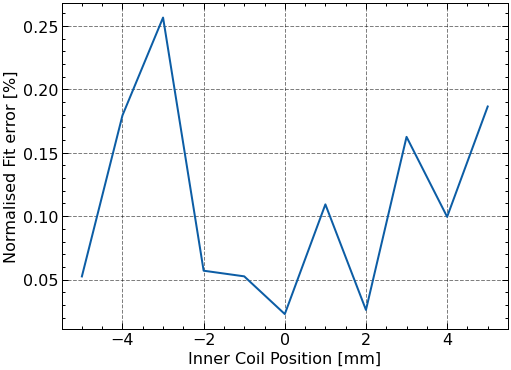

In [29]:
def polyfunc(x, a, b, c):
    return a*x**2 + b*x + c

Norm_Magnet_Forces = Magnet_Forces/OutCoil_Current 
optimizedParameters, pcov = opt.curve_fit(polyfunc, InnCoil_Positions, Norm_Magnet_Forces)
print("Fitted parameters of function:", optimizedParameters)
fitted_Norm_Magnet_Forces = polyfunc(InnCoil_Positions, *optimizedParameters)

plt.plot(InnCoil_Positions, Norm_Magnet_Forces, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_Magnet_Forces, '--', label="poly2 fit")
plt.ylabel('Normalised Magnet Force [N/A]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

plt.plot(InnCoil_Positions, Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)
plt.ylabel('Fit error [N/A]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(Norm_Magnet_Forces - fitted_Norm_Magnet_Forces)/abs(Norm_Magnet_Forces)*100)
plt.ylabel('Normalised Fit error [%]')
plt.xlabel('Inner Coil Position [mm]')
#plt.ylim(0.0,0.01)
plt.show()

In [30]:
femm.closefemm()